In [2]:
"""Dependencies"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import yaml
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'src'))
import pickle
import joblib
import src.utils as utils

In [3]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [4]:
"""Load Constant Variables"""

TARGET_COL = config['data_source']['target_col']
TEST_SZ = config['data_source']['test_size']
SEED_ST = config['data_source']['random_state']
NUM_COLS = config['data_source']['num_cols']
CAT_COLS = config['data_source']['cat_cols']
CORR_COLS = config['data_source']['corr_cols']
X_TRAIN_PATH = config['pickle_path']['X_train']
X_TEST_PATH = config['pickle_path']['X_test']
X_VALID_PATH = config['pickle_path']['X_valid']
y_TRAIN_PATH = config['pickle_path']['y_train']
y_TEST_PATH = config['pickle_path']['y_test']
y_VALID_PATH = config['pickle_path']['y_valid']

In [5]:
"""Desirialize Pickle Data"""
var_name = ["X_train", "X_test", "X_valid", "y_train", "y_test", "y_valid"]
stock_list = [X_TRAIN_PATH, X_TEST_PATH, X_VALID_PATH, y_TRAIN_PATH, y_TEST_PATH, y_VALID_PATH]
for var_name, path in zip(var_name, stock_list):
    globals()[var_name] = utils.deserialize_data(path)

## Testing Deserialize data

In [6]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
29762,45,37500,MORTGAGE,1.0,DEBTCONSOLIDATION,B,5000,11.49,0.13,N,16
2714,25,50000,RENT,5.0,PERSONAL,A,12000,7.88,0.24,N,2
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,0.38,Y,4
28458,31,78504,RENT,2.0,EDUCATION,C,10000,11.41,0.13,N,7
3674,26,14000,RENT,2.0,VENTURE,B,4000,NaN,0.29,N,3


In [7]:
y_train.head()

29762    0
2714     0
50       1
28458    0
3674     1
Name: loan_status, dtype: int64

In [8]:
NUM_COLS

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [9]:
CAT_COLS

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26064 entries, 29762 to 615
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  26064 non-null  int64  
 1   person_income               26064 non-null  int64  
 2   person_home_ownership       26064 non-null  object 
 3   person_emp_length           25352 non-null  float64
 4   loan_intent                 26064 non-null  object 
 5   loan_grade                  26064 non-null  object 
 6   loan_amnt                   26064 non-null  int64  
 7   loan_int_rate               23579 non-null  float64
 8   loan_percent_income         26064 non-null  float64
 9   cb_person_default_on_file   26064 non-null  object 
 10  cb_person_cred_hist_length  26064 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 2.4+ MB


In [11]:
X_train_num = X_train[NUM_COLS]
X_train_cat = X_train[CAT_COLS]

### Check for duplicates

In [12]:
X_train.duplicated(keep=False).sum()

220

In [13]:
dupes_X_train = X_train[X_train.duplicated(keep=False)]
dupes_X_train["person_income"].sort_values(ascending=False)

27881    604000
28770    604000
32047    250000
29160    250000
238      183000
          ...  
2498      18000
18261     18000
17601     18000
15952      7800
16821      7800
Name: person_income, Length: 220, dtype: int64

In [14]:
dupes1 = [27881, 28770]
X_train.loc[dupes1].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
27881,28,604000,MORTGAGE,12.0,PERSONAL,B,25000,9.01,0.04,N,9
28770,28,604000,MORTGAGE,12.0,PERSONAL,B,25000,9.01,0.04,N,9


In [15]:
dupes2 = [238, 16926]
X_train.loc[dupes2].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
238,22,183000,MORTGAGE,3.0,EDUCATION,A,1000,NaN,0.01,N,2
16926,22,183000,MORTGAGE,3.0,EDUCATION,A,1000,NaN,0.01,N,2


##### Conclusion
From this exploration we know that the values are REAL, however they are duplicated in the dataset for unknown reason. Therefore, we should keep only one value of the duplicated rows, in this case we use keep=last as the solution

In [16]:
print(X_train.shape)
X_train = X_train.drop_duplicates(keep="last")
print(f"\nShape after dropping:{X_train.shape}")

(26064, 11)

Shape after dropping:(25954, 11)


### Check for missing values

In [17]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
29762,45,37500,MORTGAGE,1.0,DEBTCONSOLIDATION,B,5000,11.49,0.13,N,16
2714,25,50000,RENT,5.0,PERSONAL,A,12000,7.88,0.24,N,2
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,0.38,Y,4
28458,31,78504,RENT,2.0,EDUCATION,C,10000,11.41,0.13,N,7
3674,26,14000,RENT,2.0,VENTURE,B,4000,NaN,0.29,N,3


In [18]:
X_train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              707
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2474
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

##### Conclusion
-  There are some missing values in the numerical feature `person_emp_length` and `loan_int_rate`. Since these features are important features to predict Non-Performing Loan (NPL) and we dont have any additional information to why the values are missing in the first place, we should remove all rows that has the missing values from the train dataset.


 - There are no missing values for categorical features. Therefore, our pipeline only need encoding for these features.

In [19]:
print(f"\nShape before dropping missing values:{X_train.shape}")
X_train = X_train.dropna(subset=["person_emp_length", "loan_int_rate"])
print(f"\nShape after dropping missing values:{X_train.shape}")


Shape before dropping missing values:(25954, 11)

Shape after dropping missing values:(22822, 11)


## Explorative Data Analysis

In [20]:
X_train_ = X_train[NUM_COLS]
X_train_.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
29762,45,37500,1.0,5000,11.49,0.13,16
2714,25,50000,5.0,12000,7.88,0.24,2
28458,31,78504,2.0,10000,11.41,0.13,7
23952,28,68000,7.0,3000,5.42,0.04,10
25995,28,95000,3.0,4800,11.71,0.05,10


In [21]:
print(X_train_.shape)

(22822, 7)


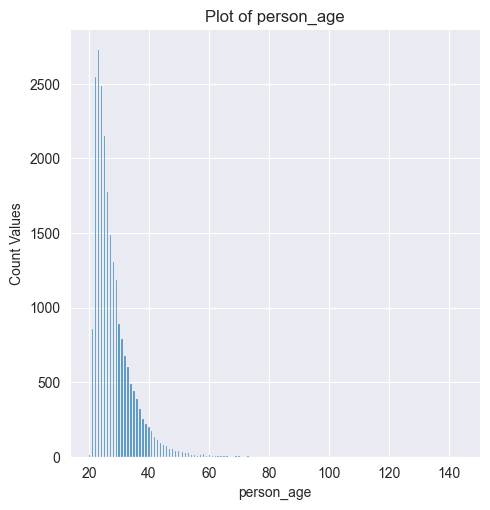

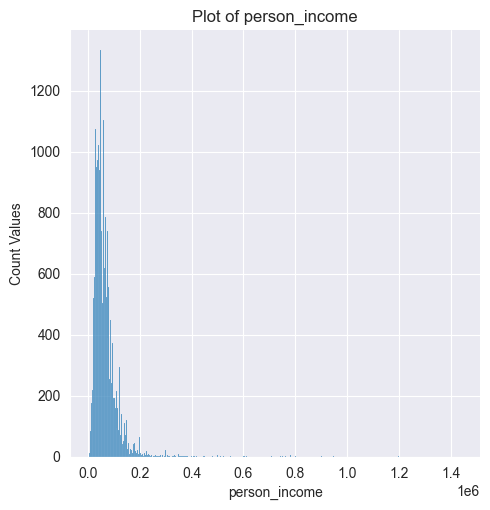

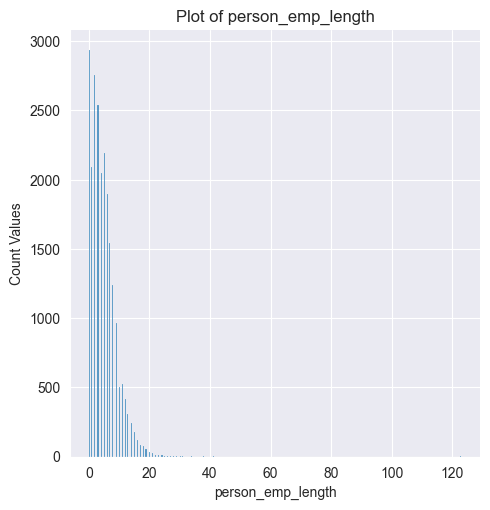

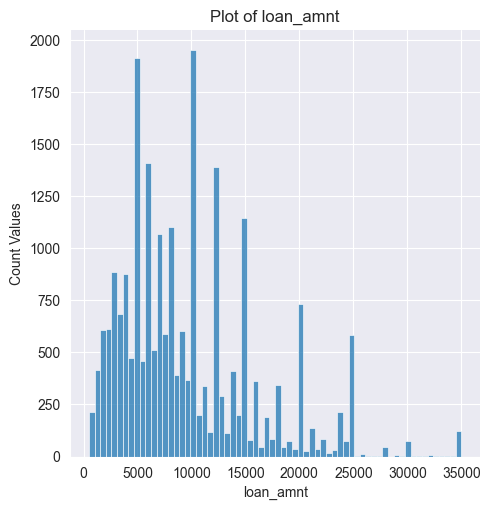

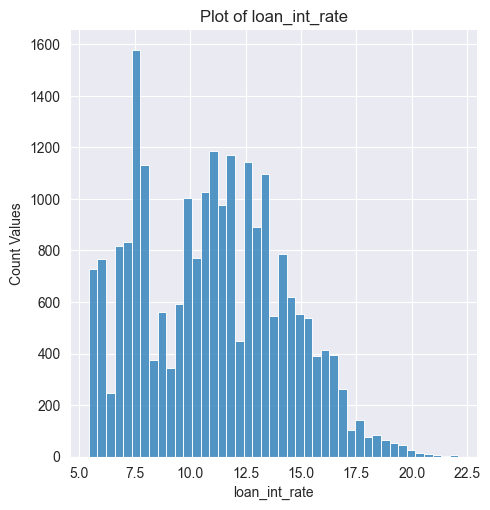

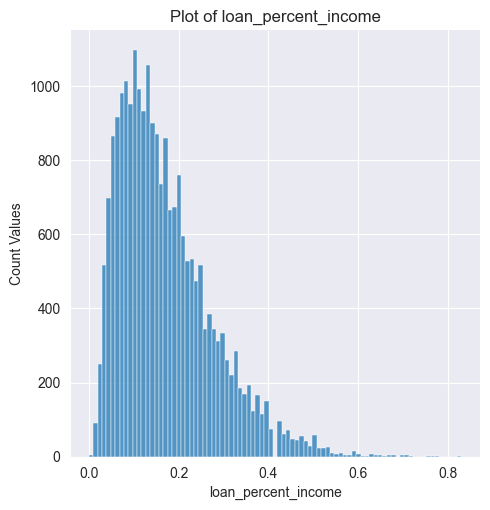

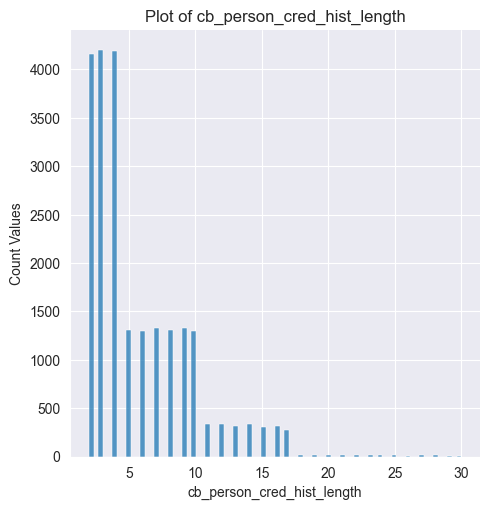

In [22]:
for i, col_name in enumerate(NUM_COLS):
    sns.displot(data=X_train_, x=X_train_[col_name])
    plt.title(f"Plot of {str(col_name)}")
    plt.ylabel("Count Values")
    plt.xlabel(str(col_name))


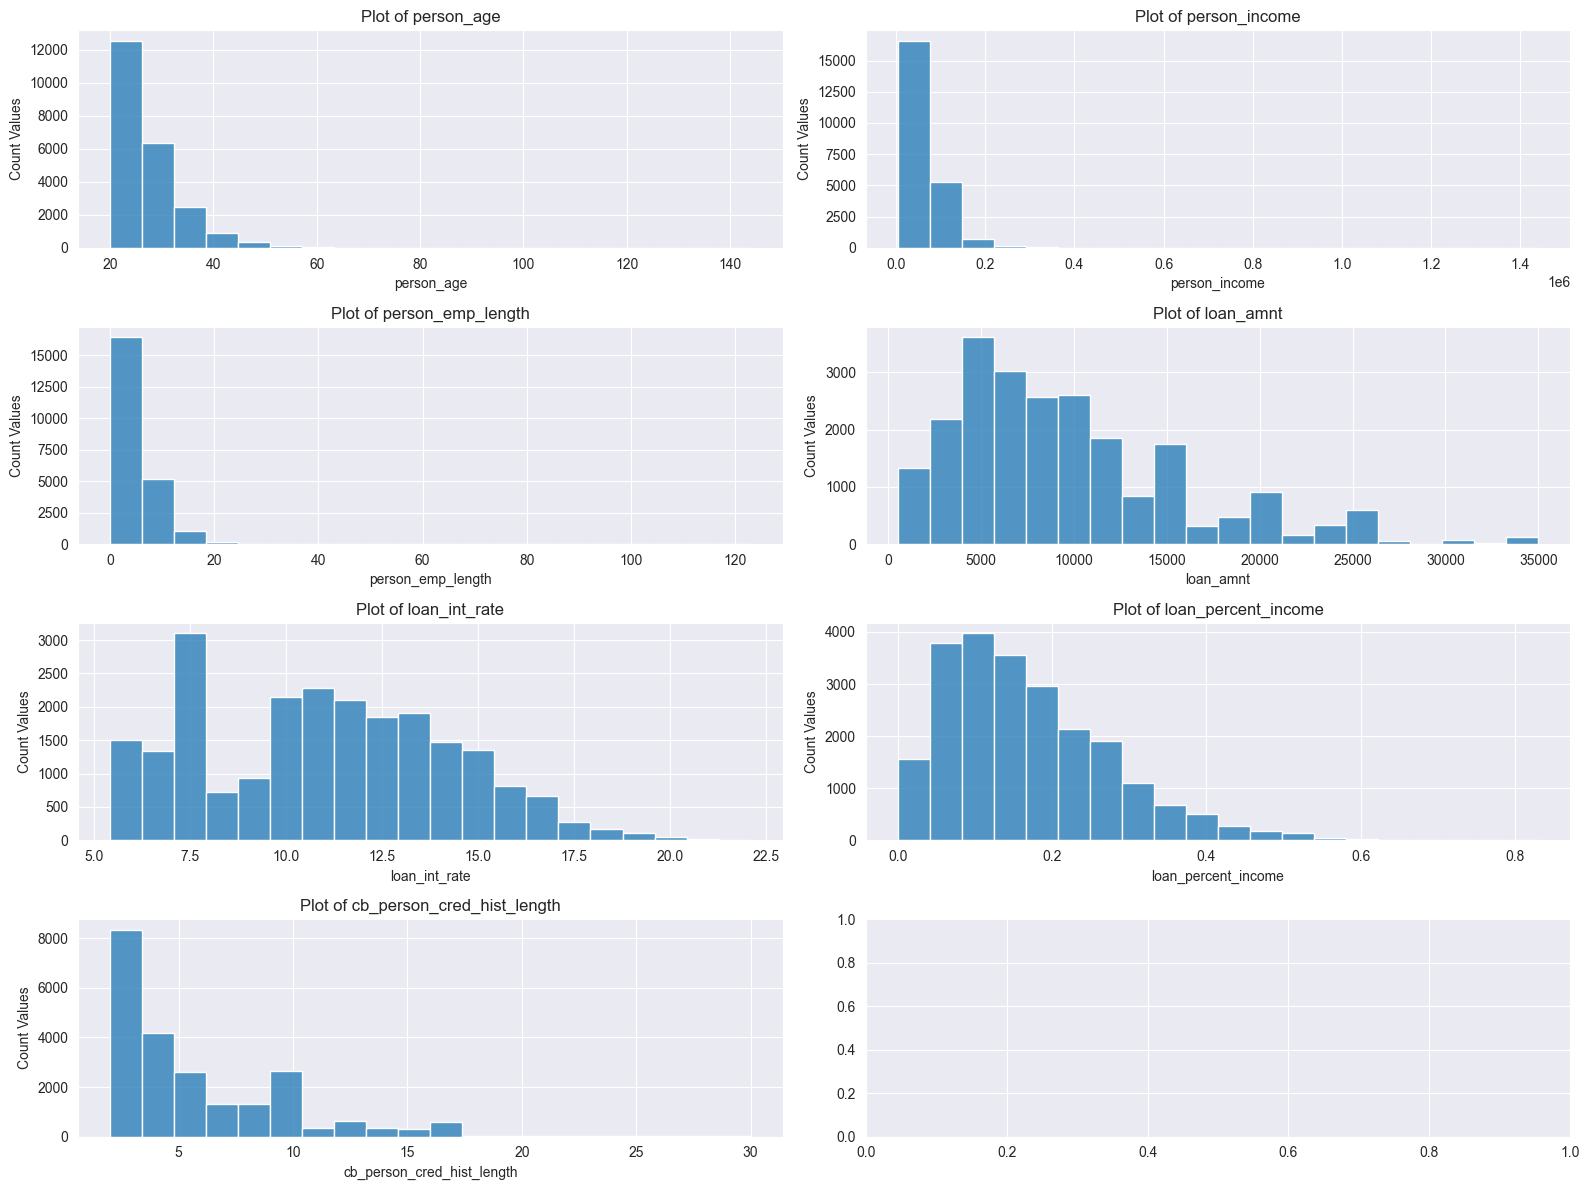

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16,12))
axes = ax.flatten()

for i, col_name in enumerate(NUM_COLS):
    sns.histplot(data=X_train_, x=col_name, bins=20, ax=axes[i])
    axes[i].set_title(f"Plot of {str(col_name)}")
    axes[i].set_ylabel("Count Values")
    axes[i].set_xlabel(str(col_name))

plt.tight_layout()
plt.show()

C:\Users\Andreas Aditya\AppData\Local\Temp\ipykernel_9948\1121714214.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels())
C:\Users\Andreas Aditya\AppData\Local\Temp\ipykernel_9948\1121714214.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels())
C:\Users\Andreas Aditya\AppData\Local\Temp\ipykernel_9948\1121714214.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels())


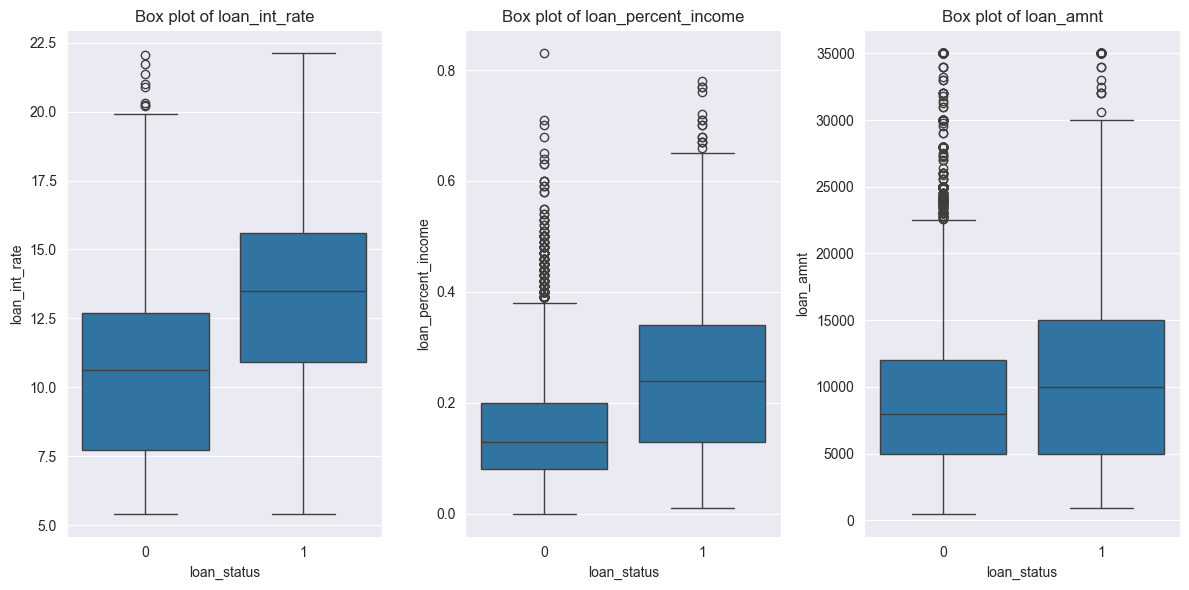

In [24]:
## additional exploration
cols = ["loan_int_rate", "loan_percent_income", "loan_amnt"]
y_train_ = y_train[y_train.index.isin(X_train_.index)]
train_data = pd.concat([X_train, y_train_], axis=1)

## Plotting freatures and target collumns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

for i, col in enumerate(cols):
  sns.boxplot(data=train_data, x="loan_status", y=col, ax=axes[i])
  axes[i].set_xticklabels(axes[i].get_xticklabels())
  axes[i].set_title(f"Box plot of {col}")

plt.tight_layout()
plt.show()

**Insights:**

The first two variables revealed a pattern that default users might be affected by high interest rate and have a higher loan income ratio than non-default user. <br>

Both of these assumptions appear logical. The higher the loan-to-income ratio an applicant possesses, the lesser their disposable income becomes. This prompts the applicant to reevaluate their needs resulting in an higher awareness towards their financial management. However, this might not be the case for everyone as they have different financial background and knowledge.

The same goes for 'loan_int_rate'. High interest rate means cutback on one's disposable income. However, interest rate is usually a long term payment which can fluctuates depending on other economic factors. During years with inflated market (e.g: high-inflation) government might be incline to hike the interest rate and in reverse, cuts rates when the economy looks weak (high unemployment). Furthermore, this predictor may have different value depending on the loan intention.

# Extra-Miles from Class

This is the exploration for individual parameters. The result of this step is a cut-off value for each parameters or concept for feature engineering in the data preprocessing steps.

### 1. Applicant Age - `person_age`

In [25]:
train_data["person_age"].value_counts().sort_index(ascending=True).tail(10)

person_age
65     4
66     6
69     4
70     5
73     2
76     1
78     1
80     1
123    1
144    1
Name: count, dtype: int64

In [26]:
train_data["person_age"].value_counts().sort_index(ascending=True).head(5)

person_age
20      11
21     855
22    2545
23    2724
24    2483
Name: count, dtype: int64

In [27]:
test_1 = train_data.query("person_age > 100")
test_1

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0


Common prerequisites for **applying for loan requires a person to be at legal age(> 18)**. Eventough there are no age limitation to take loans, some data points suggest there may be applicants with age > 100. we can set the 100 y.o. mark as maximum threshold for loan applicant.

### 2. Loan Interest Rate - `loan_int_rate`

<Axes: xlabel='loan_intent', ylabel='loan_int_rate'>

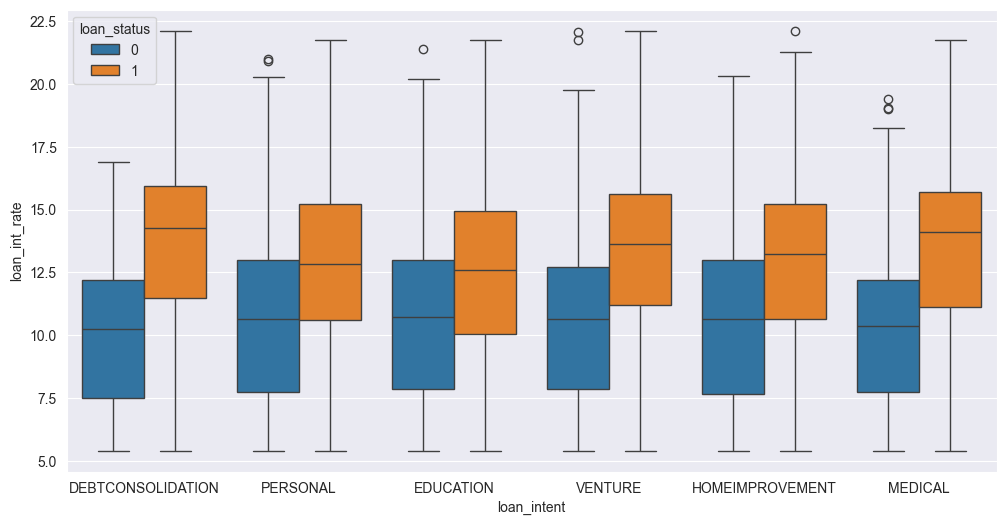

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_data, x="loan_intent", y="loan_int_rate", hue="loan_status")

- Surprisingly there are no significant difference between interest rate for different loan intention which leads to  minimal outliers.

- Normally this variable can not have empty value nor it will be 0 due to the nature of a loan and economoical situation which determines the interest rate for a loan.

- Therefore its important to drop rows that have missing value in this variables.

### 3. Employment Length - `person_emp_length`

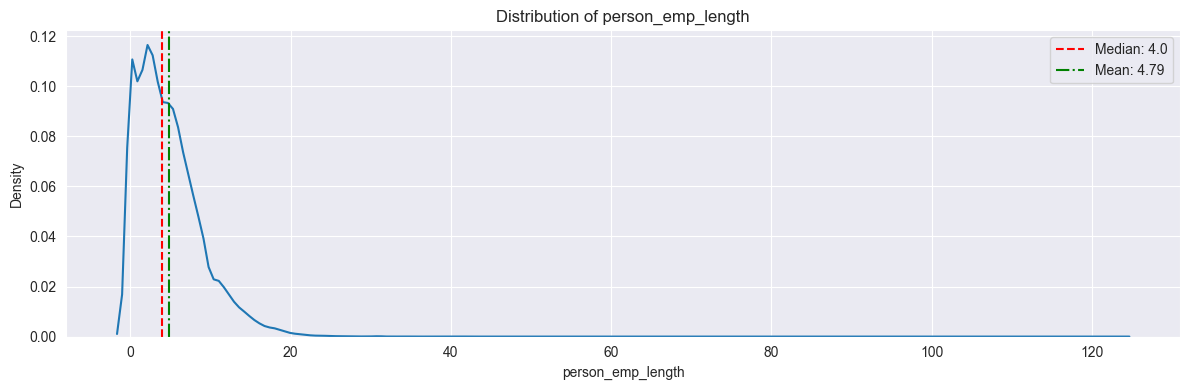

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

# plot for person_emp_length
sns.kdeplot(train_data["person_emp_length"], ax=ax)
ax.set_title('Distribution of person_emp_length')

## add median line and legend in the plot
idx_med = train_data["person_emp_length"].median()
idx_avg = train_data["person_emp_length"].mean()

ax.axvline(x=idx_med, color='r', linestyle='--', label='Median: ' + str(round(idx_med, 2)))
ax.axvline(x=idx_avg, color='g', linestyle='-.', label='Mean: ' + str(round(idx_avg, 2)))
ax.legend()

plt.tight_layout()
plt.show()

this variable is tail heavy which might have errors in them (i.e: there are people with > 40 years of employment). Normally, people have a career between 20-40 years before retirement age. we have to investigate this anomaly further.

In [30]:
query_1 = train_data.query("person_age < 100")
head_emp = query_1["person_emp_length"].value_counts().sort_index(ascending=False).head(5)
tail_emp = query_1["person_emp_length"].value_counts().sort_index(ascending=False).tail(5)

df_emp_leng = pd.concat([head_emp, tail_emp], axis=0)
df_emp_leng

person_emp_length
123.0       1
41.0        1
38.0        1
34.0        1
31.0        4
4.0      2046
3.0      2540
2.0      2755
1.0      2094
0.0      2934
Name: count, dtype: int64

In [31]:
train_data.query("person_emp_length == 123")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1


From this investigation, this data is impossible because the applicant is only 22 yo with 123 years of working experience. we can remove this one.

It would also be beneficial when the input is filtered from anomalous data where person_emp_length is bigger than person_age. additionally, We can use the common career trajectory to create a threshold for anomalous data.

This consideration considers minimum ratio of age-employment ratio i.e: maximum age of first employment and** maximum age-employment ratio** a person can legally reach. The calculation is illustrated below:

![person_emp_leng](image/person_emp_leng.PNG)

from the calculation there are two threshold which shows the maximum and minimum of age-employment ratio.

The minimum ratio implies that the maximum risk our bank can accept is a working class person who started their carrer at 30 years old. This consideration is made due to the dynamic nature of rising unemployment rate amongst youth and graduates.

The maximum ratio implies that the minimal risk our bank can accept is a working class person who started their carrer early on at 18 y.o (minimum legal age). This consideration takes into account applicant who have started their carrer right after highschool and continous to work until the retirement age.

The ratio in between captures the dynamic of the job market where person can be employed and have a carrer break or started late.

The ratio outside of the threshold indicates that applicant may have not sufficient means of income history or fallen out of job market. Here are coverage example of some unsual cases that this consideration handles:

Applicant works at the early age of 18 then stopped working at 22 due to disabilities, then at the age of 56 they apply for medical loan. Ratio = 4 / 56 --> 0.07 still eligible for loan

exceeding this maximum ratio means incorect data was collected or applicant may worked more than its legally allowed

Eventough this approach is a good filter for input data, it will remove some applicant that do not have employment history but able to finance their loan through other means (i.e: P2P-Lending, Secured Loans, Guarantor Loans, etc.).

Since there are no more information of which kind of loan is given nor the source of income the applicant has. This measures provide a good safe guarding techniques with the limited information available.